In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.types import StructType, StructField, DoubleType,IntegerType
from pyspark.sql import Row
from pyspark.sql.functions import array, lit,udf
import time
from sklearn.metrics import silhouette_samples, silhouette_score


# MiniBatch K-means Algorithm
The idea and concept of this Mini K-means Implemantion has been taken from 
`Sculley, David. "Web-scale k-means clustering." Proceedings of the 19th international conference on World wide web. 2010.`

### Clustering error function

In [2]:
def clustering_error_inf(centroids, data_points):
    num_points = data_points.shape[0]
    
    num_clusters = centroids.shape[0]
    
   
    # Quadratic distance between given points and cluster centroids
    distances = np.zeros(num_points)
    for i in range(num_points):
        point = data_points[i]
        distances[i] = np.min(np.sum((centroids - point) ** 2, axis=1))

    # Mean Squared Error (MSE)
    mse = np.sum(distances) / num_points

    return mse

def compute_distances(X, centroids):
    """ 
    Return Euclidean distance between points and centroids
    assuming both to have the same number of dimensions
    """
    # Assuming X and centroids have the same number of dimensions
    s_sq_difference = np.sum((X - centroids)**2, axis=1)
    distances = np.sqrt(s_sq_difference)
    
    return distances

def compute_distance(point, centroids):
    return np.linalg.norm(point - centroids, axis=1) ** 2



### Cost Function

In [3]:
def cost(X, centroids):
    """
    Estimation of algorithm mean cost function.
    
    Args:
        X (numpy array): (n_samples, n_features).
        centroids (numpy array): (n_clusters, n_features).
    
    Returns:
        float
    """
    n_samples = X.shape[0]
    n_clusters = centroids.shape[0]

    # Quadratic distance between points and centroids
    distances = np.zeros(n_samples)
    for i in range(n_samples):
        point = X[i]
        squared_distances = np.sum((centroids - point) ** 2, axis=1)
        min_distance = np.min(squared_distances)
        distances[i] = min_distance

    # Total cost with minimum distance
    total_cost = np.sum(distances)
    
    return total_cost/n_samples



### MiniBatch K-means function

In [4]:
def mini_kmeans(X, sc, num_clusters=5, iteration=10, batch_size=20, n_partitions=20):
    k = num_clusters
    b = batch_size
    t = iteration
    N = X.shape[0]
    C = X[np.random.choice(N, k, replace=False)]
    v = np.zeros(len(C))
    Y = np.empty(N, dtype=np.int32)
    times = []
    mse = []

    for i in range(t):
        start = time.time()
        mini_batch_idx = np.random.choice(range(N), size=b, replace=False)
        mini_batch = X[mini_batch_idx]

        if n_partitions is not None:
            dist_mini_batch_idx = sc.parallelize(mini_batch_idx, n_partitions)
        else:
            dist_mini_batch_idx = sc.parallelize(mini_batch_idx)

        distances_rdd = dist_mini_batch_idx.map(lambda x: (x, compute_distance(X[x], C)))
        nearest_cluster_rdd = distances_rdd.map(lambda x: (x[0], np.argmin(x[1], axis=0)))
        Y[mini_batch_idx] = nearest_cluster_rdd.values().collect()

        for idx in mini_batch_idx:
            v[Y[idx]] += 1
            learning_rate = 1 / v[Y[idx]]
            C[Y[idx]] = (1 - learning_rate) * C[Y[idx]] + learning_rate * X[idx]

        end = time.time()
        times.append(end - start)

        # Mean Squared Error
        mse_value = np.mean([np.min(compute_distance(X[i], C)) for i in mini_batch_idx])
        mse.append(mse_value)

    return C, times, mse

### Spark Configuration

In [5]:
sc.stop()

In [6]:
spark = SparkSession.builder \
    .appName("Mini Batch K-means")\
    .config("spark.cores.max","8")\
    .config("spark.executor.memory", "6g")\
    .getOrCreate()

# create a spark context
sc = spark.sparkContext
# print its status
sc

<SparkContext master=spark://10.67.22.233:7077 appName=Mini Batch K-means>

## DATASET GENERATION

In [7]:
num_features_=2
# Define the schema for the DataFrame
schema = StructType([
    StructField("feature1", DoubleType(), True),
    StructField("feature2", DoubleType(), True)
])

# RANDOM DATA GENERATION FUNCTION
def generate_data(num_points, num_features, num_clusters):
    data = []
    centers = [np.random.rand(num_features) * 100 for _ in range(num_clusters)]
    for _ in range(num_points):
        center = random.choice(centers)
        point = center + np.random.randn(num_features) * 3
        data.append(point.tolist())  # Convert NumPy array to Python list
    return data


data = generate_data(num_points=10000, num_features=num_features_, num_clusters=5)

data_rdd = sc.parallelize(data)
data_array=np.array(data_rdd.collect())

data_df = data_rdd.map(lambda x: (x[0], x[1])).toDF(["feature1", "feature2"])

In [8]:
start=time.time()
C_k,timeS,mse = mini_kmeans(data_array,sc,n_partitions=2,num_clusters=5 )
end=time.time()

print('Mean execution time:',round(end-start,2),'s')

Mean execution time: 2.14 s


In [9]:
# Function to assign point to a cluster through centroids
# UDF: user defined function
def assign_to_cluster_udf(features, centroids):
    point = np.array(features)
    distances = compute_distances(point, centroids)
    return int(np.argmin(distances))

assign_cluster_udf = udf(assign_to_cluster_udf, IntegerType())

# Adding clustering column to Dataframe
data_df = data_df.withColumn("cluster", assign_cluster_udf(array("feature1", "feature2"), lit(C_k.tolist())))

# Stampa i primi 10 record con la colonna "cluster" aggiunta
data_df.show(10)

+------------------+------------------+-------+
|          feature1|          feature2|cluster|
+------------------+------------------+-------+
|15.672453764573735|16.668851389289703|      0|
|13.140857559104177|16.873829834222303|      0|
| 17.51777738398345|38.284157066681495|      3|
| 10.85540726271002|15.897368295881435|      0|
|39.953377745441266|32.349732725786524|      4|
| 17.01751515402286|20.935642093532792|      0|
|12.149470660205049|12.541563748003089|      0|
|  34.7626341294516|34.816227942092496|      2|
| 18.19079601273816| 17.76010442889907|      0|
| 34.64170375693768|61.375144544714445|      1|
+------------------+------------------+-------+
only showing top 10 rows



## Plot of clusterized data

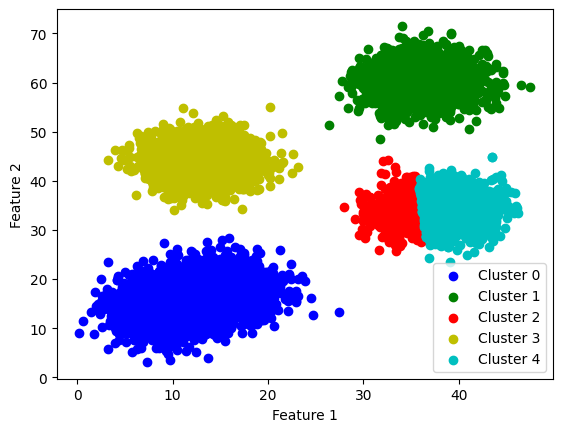

In [10]:
data_points = data_df.select("feature1", "feature2", "cluster").collect()

colors = ['b', 'g', 'r','y','c']

cluster_data = {i: [] for i in range(5)}


for row in data_points:
    cluster = row['cluster']
    cluster_data[cluster].append((row['feature1'], row['feature2']))


for cluster, points in cluster_data.items():
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    plt.scatter(x, y, c=colors[cluster], label=f'Cluster {cluster}')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')


plt.legend()

plt.show()

# Silhouette score

In [11]:
cluster_labels = np.empty(len(data_array), dtype=np.int32)
for i in range(len(data_array)):
    distances = compute_distances(data_array[i], C_k)
    cluster_labels[i] = np.argmin(distances)

# Silhouette Score
silhouette_avg = silhouette_score(data_array, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.6759890843470358


In [12]:
sc.stop()